In [1]:
import sys
import os

# Add the root project directory (i.e., the one containing both env/ and evaluation/)
sys.path.append(os.path.abspath(".."))

from greedy_comparison import *

In [9]:
random_states = generate_random_states([6, 8, 10, 12, 14, 16, 18, 20], filename = "test_states_20-06")

In [8]:
import pickle

# Load results from the specified file
# Correct the file path or ensure the file exists at the specified location
corrected_path = "../saved files/dqn/greedy_comparison/test_states_19.06.pkl"

try:
    with open(corrected_path, "rb") as file:
        test_states = pickle.load(file)
except FileNotFoundError:
    print(f"File not found at path: {corrected_path}. Please check the file path or ensure the file exists.")

In [3]:
tests = {}
tests[12] = random_states[12]

In [11]:
results = compute_greedy_polarizations([2,3,4,5,6], random_states, filename="greedy_polarizations_20-06")

100%|██████████| 8/8 [1:17:59<00:00, 584.92s/it]


In [6]:
import pickle

# Load results from the specified file
# Correct the file path or ensure the file exists at the specified location
corrected_path = "../saved files/dqn/greedy_comparison/greedy_polarizations_19.06.pkl"

try:
    with open(corrected_path, "rb") as file:
        loaded_results = pickle.load(file)
except FileNotFoundError:
    print(f"File not found at path: {corrected_path}. Please check the file path or ensure the file exists.")



In [30]:
greedy_polarizations[(6,2)] == greedy_polarizations[(6,3)]

False

In [6]:
from tqdm import tqdm
import depolarizing_functions as depf
from agents.dqn import DQN
import pickle
import json
import torch
import importlib
importlib.reload(depf)

filename_test_states = "test_states_19.06"
filename_greedy_polarizatios = "gre"
run_name = "global-simple-n12-k4-hd_default-layers4-lr0.0008-heads_default-bs40-RJ9EA"

run_dir = os.path.join("..", "saved files", "dqn", "saved_runs_dqn", run_name)
comparison_dir = os.path.join("..", "saved files", "dqn", "greedy_comparison")

with open(os.path.join(comparison_dir, f"{filename_test_states}.pkl"), "rb") as f:
        test_states = pickle.load(f)

with open(os.path.join(comparison_dir, f"{filename_greedy_polarizatios}.pkl"), "rb") as f:
        greedy_polarizations = pickle.load(f)

with open(os.path.join(run_dir, "params.json"), "r") as f:
        params = json.load(f)

params["wandb_init"] = False

# --- Initialize environment and agent ---
env = FJDepolarize(**params)
agent = DQN(env = env, **params)

# --- Load model weights ---
q_net_path = os.path.join(run_dir, "q_network_params.pth")
target_net_path = os.path.join(run_dir, "target_network_params.pth")

agent.q_network.load_state_dict(torch.load(q_net_path, map_location=torch.device("cpu")))
agent.target_network.load_state_dict(torch.load(target_net_path, map_location=torch.device("cpu")))

epsilon =  1e-4

results_test = {}
for (n, k), pols in greedy_polarizations.items():
    if (n,k) == (7,2):
          break
    env = FJDepolarize(n=n, k=k)
    polarization_diff = 0
    dqn_better = 0
    greedy_better = 0
    print(k)
    for i, state in enumerate(test_states[n]):
        state["edges_left"] = k
        _, polarization_dqn = depf.depolarize_policy(state, env, agent.policy_greedy)
        polarization_diff = polarization_diff + polarization_dqn - pols[i]
        if abs(polarization_dqn - pols[i]) > epsilon:
            if polarization_dqn < pols[i]:
                dqn_better += 1
            else:
                greedy_better += 1
    results_test[(n,k)] = {"number_states": len(test_states[n]),
                        "dqn_better": dqn_better,
                        "greedy_better": greedy_better,
                        "difference": polarization_diff}

# with open(os.path.join(run_dir, f"greedy_comparison_results.pkl"), "wb") as f:
#     pickle.dump(results, f)
    

4


In [7]:
results_test[(12,4)]

{'number_states': 500,
 'dqn_better': 132,
 'greedy_better': 256,
 'difference': np.float64(0.26526610584165455)}

In [8]:
0.2652661/500

0.0005305322

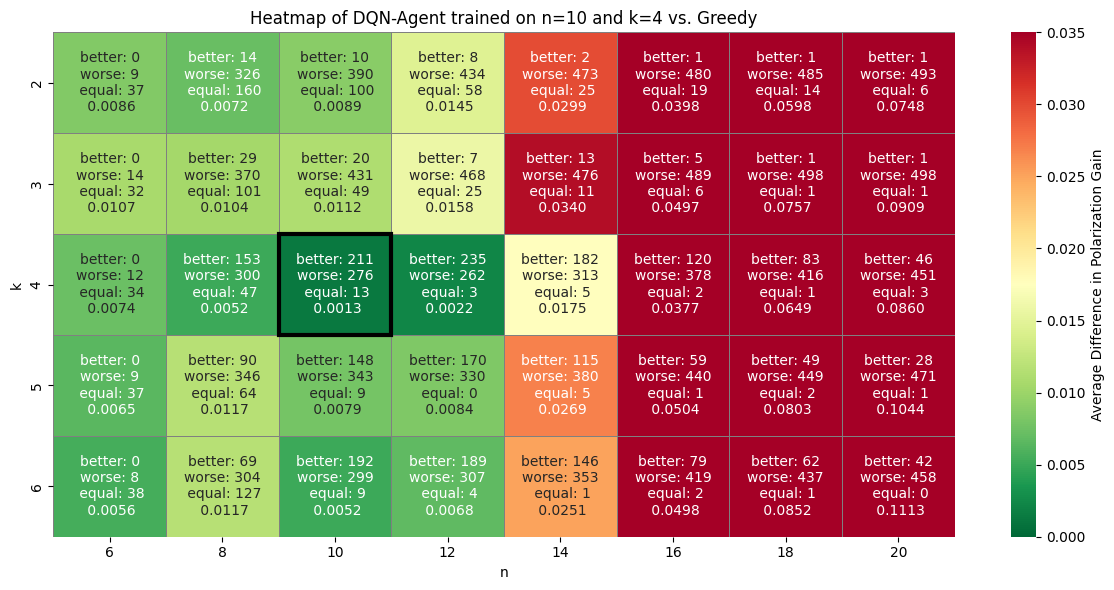

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
import numpy as np
import pandas as pd
import json

run_name = "test_graphsage_simple"

run_dir = os.path.join("..", "saved files", "dqn", "saved_runs_dqn", run_name)

with open(os.path.join(run_dir, "params.json"), "r") as f:
        params = json.load(f)

with open(os.path.join(run_dir, "greedy_comparison_results.pkl"), "rb") as f:
        results = pickle.load(f)


# Define the ranges
n_values = list({n for n, _ in results.keys()})
k_values = list({k for _, k in results.keys()})

# Create matrices for annotations and heatmap coloring
annot_matrix = []
color_matrix = []

for k in k_values:
    row_annot = []
    row_color = []
    for n in n_values:
        key = (n, k)
        if key in results:
            r = results[key]
            num = r["number_states"]
            dqn = r["dqn_better"]
            greedy = r["greedy_better"]
            diff = r["difference"]
            diff_norm = diff / num if num != 0 else 0

            # Annotation text
            annot = f"better: {dqn}\nworse: {greedy}\n equal: {num-dqn-greedy}\n {diff_norm:.4f}"

            row_annot.append(annot)
            row_color.append(diff_norm)
        else:
            row_annot.append("")
            row_color.append(np.nan)
    annot_matrix.append(row_annot)
    color_matrix.append(row_color)

# Convert to DataFrame for seaborn
annot_df = pd.DataFrame(annot_matrix, index=k_values, columns=n_values)
color_df = pd.DataFrame(color_matrix, index=k_values, columns=n_values)

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.heatmap(color_df, annot=annot_df, fmt='', cmap="RdYlGn_r", cbar_kws={'label': 'Average Difference in Polarization Gain'}, linewidths=0.5, linecolor='gray', vmin=0, vmax=0.035)

# Add black rectangle around cell for which we trained
n_target = params["n"]
k_target = params["k"]
row_idx = k_values.index(k_target) # Get the row and column indices in the matrix
col_idx = n_values.index(n_target)
rect = patches.Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='black', linewidth=3) # Rectangle parameters: (x, y) is the bottom left of the cell
ax.add_patch(rect)

plt.xlabel("n")
plt.ylabel("k")
plt.title(f"Heatmap of DQN-Agent trained on n={n_target} and k={k_target} vs. Greedy")
plt.tight_layout()
plt.show()




In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
import numpy as np
import pandas as pd
import json

run_name = "test_graphsage_simple"

run_dir = os.path.join("..", "saved files", "dqn", "saved_runs_dqn", run_name)

with open(os.path.join(run_dir, "params.json"), "r") as f:
        params = json.load(f)

with open(os.path.join(run_dir, "greedy_comparison_results.pkl"), "rb") as f:
        results = pickle.load(f)


# Define the ranges
n_values = list({n for n, _ in results.keys()})
k_values = list({k for _, k in results.keys()})

# Create matrices for annotations and heatmap coloring
annot_matrix = []
color_matrix = []

for k in k_values:
    row_annot = []
    row_color = []
    for n in n_values:
        key = (n, k)
        if key in results:
            r = results[key]
            num = r["number_states"]
            dqn = r["dqn_better"]
            greedy = r["greedy_better"]
            diff = r["difference"]
            diff_norm = diff / num if num != 0 else 0

            # Annotation text
            annot = f"better: {dqn}\nworse: {greedy}\n equal: {num-dqn-greedy}\n {diff_norm:.4f}"

            row_annot.append(annot)
            row_color.append(diff_norm)
        else:
            row_annot.append("")
            row_color.append(np.nan)
    annot_matrix.append(row_annot)
    color_matrix.append(row_color)

# Convert to DataFrame for seaborn
annot_df = pd.DataFrame(annot_matrix, index=k_values, columns=n_values)
color_df = pd.DataFrame(color_matrix, index=k_values, columns=n_values)

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.heatmap(color_df, annot=annot_df, fmt='', cmap="RdYlGn_r", cbar_kws={'label': 'Average Difference in Polarization Gain'}, linewidths=0.5, linecolor='gray', vmin=0, vmax=0.035)

# Add black rectangle around cell for which we trained
n_target = params["n"]
k_target = params["k"]
row_idx = k_values.index(k_target) # Get the row and column indices in the matrix
col_idx = n_values.index(n_target)
rect = patches.Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='black', linewidth=3) # Rectangle parameters: (x, y) is the bottom left of the cell
ax.add_patch(rect)

plt.xlabel("n")
plt.ylabel("k")
plt.title(f"Heatmap of DQN-Agent trained on n={n_target} and k={k_target} vs. Greedy")
plt.tight_layout()

# Save the figure to the specified path
save_path = os.path.join(run_dir, "heatmap_dqn_vs_greedy.png")
plt.savefig(save_path)
plt.close()


